<img src="https://platforma.gik.pw.edu.pl/themes/konkurs/logo.png">

# Deep learning w GIS, Maria Sokołowska

In [146]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.utils import to_categorical
import numpy as np
import tifffile as tiff
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML

## Sieć neuronowa

<img src="https://chucksblog.typepad.com/.a/6a00d83451be8f69e201bb07e83109970d-800wi">
chucksblog.typepad.com

## Wczytanie danych

In [147]:
def shuffle_in_unison(a, b):
    """
    Miesza a, b i c, ale tak by indeksy dalej sobie odpowiadaly
    :param a: numpy array
    :param b: numpy array
    :param c: numpy array
    :return: pomieszane numpy arraye
    """
    assert len(a) == len(b)
    np.random.seed(42)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [148]:
def read_data(path):
    """
    Zwraca dataset (data), etykiety numeryczne (labels) i nazwy klas/katalogow (classes)
    data, labels -> numpy array
    classes -> lista
    :param path: sciezka do katalogu z katalogami z danymi
    """
    cls = 0
    classes = {}
    data = []
    labels = []
    names = []
    dirs = os.listdir(path)
    for dir in dirs:
        files = os.listdir(path + "/" + dir)
        for file in files:
            if not file.rsplit(".", 1)[1].lower() in ["tif"]:
                continue
            else:
                # wczytanie obrazu
                filepath = path + "/" + dir + "/" + file
                image = tiff.imread(filepath)
                data.append(image)
                labels.append(cls)
        classes[cls] = dir
        cls += 1

    # miesza dane i etykiety, ale tak by nadal sobie odpowiadaly
    data = np.stack(data)
    data, labels = shuffle_in_unison(np.array(data), np.array(labels))
    return data, labels, classes

In [149]:
data, labels, classes = read_data("/home/mery/tif")
"Wymiar tensora z danymi wejściowymi: {}".format(data.shape)
"Wymiar wektora z etykietami danych wejśćiowych: {}".format(labels.shape)


'Wymiar wektora z etykietami danych wejśćiowych: (27000,)'

[Text(0, 0, 'Residential'),
 Text(0, 0, 'AnnualCrop'),
 Text(0, 0, 'PermanentCrop'),
 Text(0, 0, 'Pasture'),
 Text(0, 0, 'HerbaceousVegetation'),
 Text(0, 0, 'River'),
 Text(0, 0, 'Highway'),
 Text(0, 0, 'Forest'),
 Text(0, 0, 'Industrial'),
 Text(0, 0, 'SeaLake')]

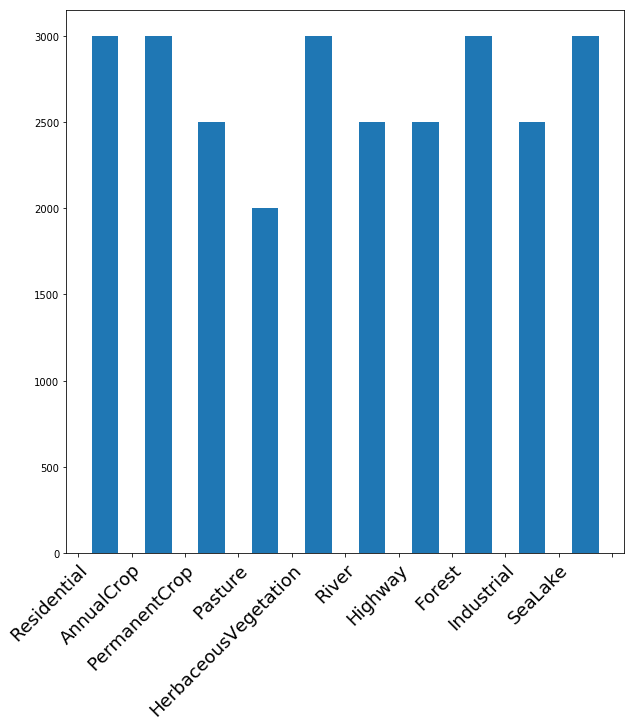

In [166]:
plt.figure(figsize=(10,10))
axes = plt.subplot()
counts, bins, patches = axes.hist(labels, rwidth=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(list(classes.values()), rotation=45, rotation_mode="anchor", ha="right", fontsize=18)


## Podział danych na trenujące i walidacyjne

In [151]:
dataset_size = data.shape[0]
train_size = int(0.9 * dataset_size) # 90% datasetu (mozna tym manipulowac)
X_train = data[0:train_size, ]
y_train = labels[0:train_size]
X_test = data[train_size:, ]
y_test = labels[train_size:, ]

In [152]:
dataset_size

27000

In [153]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24300, 64, 64, 13), (24300,), (2700, 64, 64, 13), (2700,))

## Wyświetlenie próbki danych

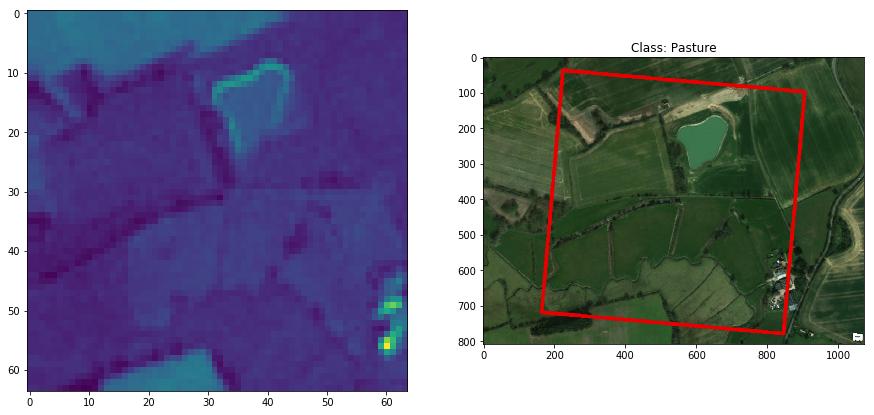

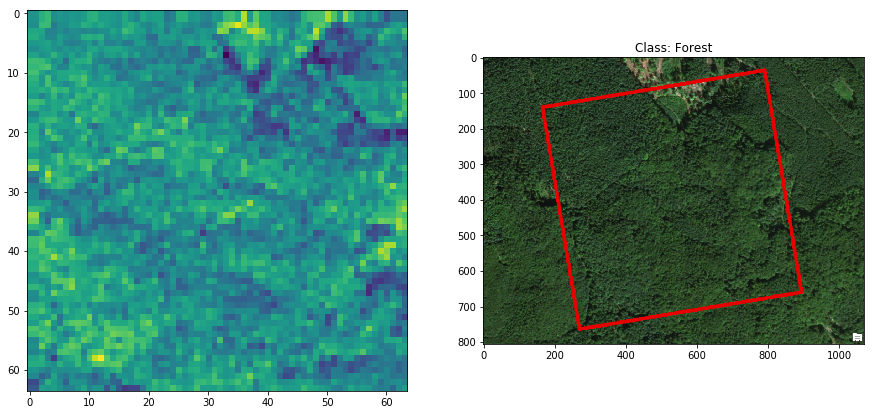

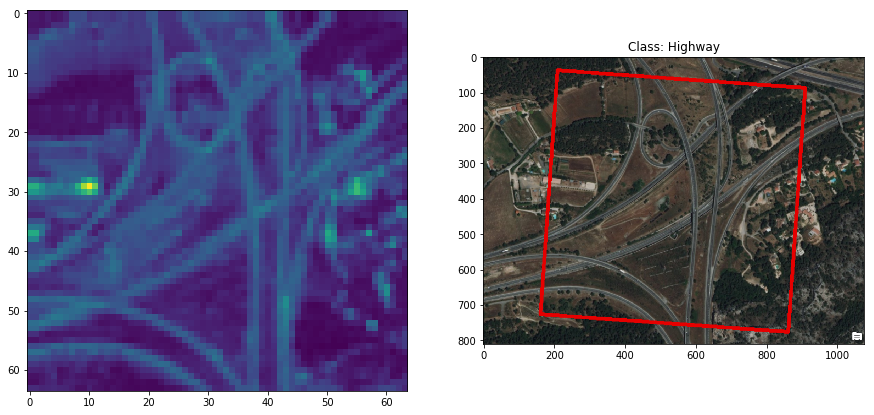

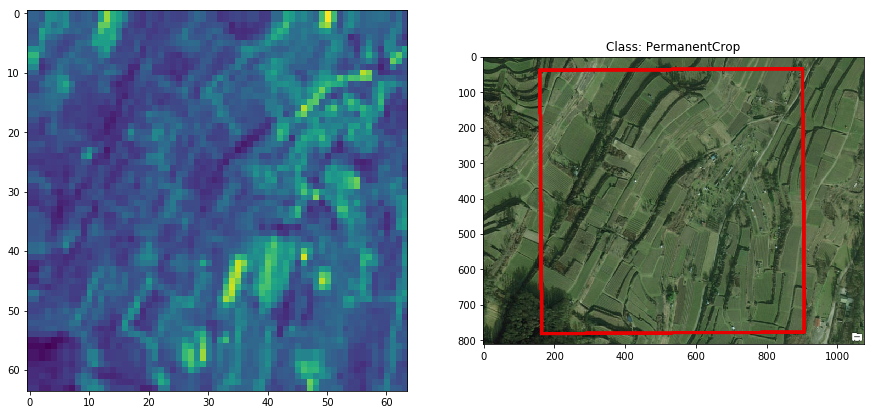

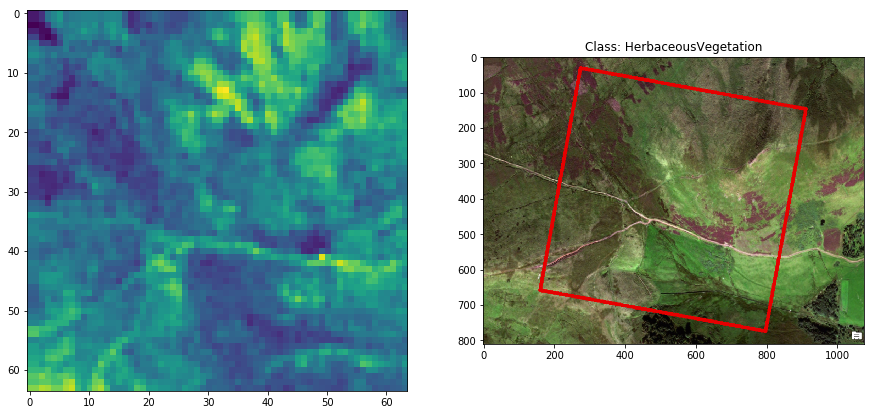

In [154]:
dataset_samples=['img/Pasture115.PNG', 'img/Forest633.PNG', 'img/Highway2160.PNG',
                 'img/PernamentCrop2385.PNG', 'img/HerbaceousVegatation444.PNG']
for idx in range(5):
    image = X_train[idx, :, :,1]
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(Image.open(dataset_samples[idx]))
    plt.title('Class: {}'.format(classes[y_train[idx]]))
    plt.show()

## Normalizacja i kategoryzacja danych

In [155]:
np.max(X_train), np.min(X_train)
np.max(X_test), np.min(X_test)
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

num_classes = np.unique(labels).shape[0]
if len(y_train.shape) == 1:
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

## Konwolucyjna sieć neuronowa

<img src="https://devblogs.nvidia.com/wp-content/uploads/2015/11/hierarchical_features.png">
devblogs.nvidia.com

In [156]:
input_shape = X_train[0].shape

In [157]:

model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape),
        # wartosci w kernelu sa zazwyczaj z rozkladu gaussa
        # liczba filtrow to liczba nalozen kernela
    
        MaxPool2D(pool_size=(2, 2)),  # pooling na przefiltrowanym bierze max z okna 2x2 i zmniejsza rozmiar img

        Conv2D(filters=64, kernel_size=(3, 3)),  # conv2d i pooling na wyniku pierwszego zestawu
        MaxPool2D(pool_size=(2, 2)),

        Flatten(),  # obrazek po konwolucjach -> liczba pikseli x 1

        Dense(512, activation='relu'),  # fullyconnected ma 512 neuronow, dokladane do flatten, mozna te liczbe zmieniac

        Dense(num_classes, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Trenowanie modelu

In [158]:
model.fit(
        X_train, y_train,
        batch_size=128, #dzielnik rozmiaru X_train
        epochs=3, #ok. 5-7
        validation_data=(X_test, y_test)
    )

Train on 24300 samples, validate on 2700 samples
Epoch 1/3
24300/24300 [==============================] - 122s 5ms/step - loss: 0.8930 - acc: 0.6762 - val_loss: 0.6904 - val_acc: 0.7552
Epoch 2/3
24300/24300 [==============================] - 112s 5ms/step - loss: 0.5351 - acc: 0.8083 - val_loss: 0.5000 - val_acc: 0.8185
Epoch 3/3
24300/24300 [==============================] - 112s 5ms/step - loss: 0.4242 - acc: 0.8481 - val_loss: 0.4186 - val_acc: 0.8500


## Testowanie

In [160]:
score = model.evaluate(X_test, y_test, verbose=0)  # zwraca [loss, accuracy]

In [171]:
"Dokładność: {0:.2%}".format(score[1])

'Dokładność: 90.37%'

In [162]:
X_new = X_test[:5]
y_new_ground_truth = y_test[:5]
y_new = model.predict(X_new)
classes

{0: 'Residential',
 1: 'AnnualCrop',
 2: 'PermanentCrop',
 3: 'Pasture',
 4: 'HerbaceousVegetation',
 5: 'River',
 6: 'Highway',
 7: 'Forest',
 8: 'Industrial',
 9: 'SeaLake'}

Powinno być: SeaLake
Rozpoznano: SeaLake


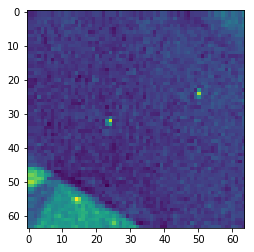

Powinno być: Forest
Rozpoznano: Forest


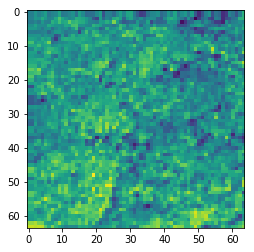

Powinno być: PermanentCrop
Rozpoznano: PermanentCrop


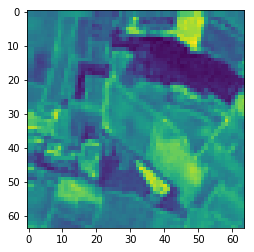

Powinno być: Residential
Rozpoznano: Residential


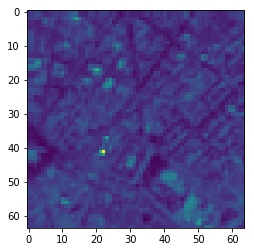

Powinno być: PermanentCrop
Rozpoznano: HerbaceousVegetation


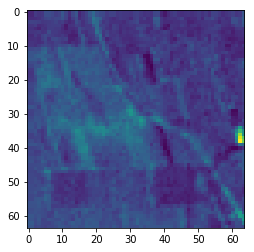

In [163]:
for i in range(len(X_new)):
    y_new_rounded = [ '%.2f' % elem for elem in y_new[i] ]
    y_new_ground_truth_rounded = [ '%.2f' % elem for elem in y_new_ground_truth[i] ]
    type(y_new_rounded)
    plt.imshow(X_test[i, :, :,1])
    print('Powinno być: {}'.format(classes[y_new_ground_truth_rounded.index(max(y_new_ground_truth_rounded))]))
    print('Rozpoznano: {}'.format(classes[y_new_rounded.index(max(y_new_rounded))]))
    plt.show()

In [167]:
model.fit(
        X_train, y_train,
        batch_size=128, #dzielnik rozmiaru X_train
        epochs=7, #ok. 5-7
        validation_data=(X_test, y_test)
    )
score = model.evaluate(X_test, y_test, verbose=0)  # zwraca [loss, accuracy]


Train on 24300 samples, validate on 2700 samples
Epoch 1/7
24300/24300 [==============================] - 113s 5ms/step - loss: 0.3516 - acc: 0.8768 - val_loss: 0.4404 - val_acc: 0.8389
Epoch 2/7
24300/24300 [==============================] - 112s 5ms/step - loss: 0.2652 - acc: 0.9064 - val_loss: 0.2896 - val_acc: 0.8919
Epoch 4/7
24300/24300 [==============================] - 112s 5ms/step - loss: 0.2509 - acc: 0.9133 - val_loss: 0.2750 - val_acc: 0.9059
Epoch 5/7
24300/24300 [==============================] - 112s 5ms/step - loss: 0.2193 - acc: 0.9244 - val_loss: 0.2592 - val_acc: 0.9078
Epoch 6/7
24300/24300 [==============================] - 112s 5ms/step - loss: 0.1797 - acc: 0.9390 - val_loss: 0.2734 - val_acc: 0.9067
Epoch 7/7
24300/24300 [==============================] - 112s 5ms/step - loss: 0.1771 - acc: 0.9379 - val_loss: 0.3076 - val_acc: 0.9037


In [169]:
"Dokładność: {0:.2%}".format(score[1])

'Dokładność: 90.37%'